In [1]:
# !pip3 install transformers
# !pip3 install sentencepiece

In [2]:
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

/home/jwkim/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# # Dataset
# class BoWDataset(torch.utils.data.Dataset):
#     def __init__(self, tokenizer, input_set):
#         self.tokenizer = tokenizer
#         self.texts = input_set['text']
#         self.labels = input_set['label']

#         vectoriser = CountVectorizer(tokenizer=self.tokenizer.tokenize, max_features=10000)
#         self.X = vectoriser.fit_transform(self.texts)
        
#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         item = {
#             'text': self.X[idx],
#             'label': self.labels[idx],
#         }
#         return item

In [42]:
# # Experiment: Use BERT tokeniser or random tokeniser
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [3]:
train_df = pd.read_csv('../data/train.tsv',  sep='\t')
val_df = pd.read_csv('../data/valid.tsv',  sep='\t')
test_df = pd.read_csv('../data/dev.tsv',  sep='\t')

In [4]:
# Clean data
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()
print(f"Train dataset size: {len(train_df)}")
print(f"Validation dataset size: {len(val_df)}")
print(f"Test dataset size: {len(test_df)}")

Train dataset size: 6700
Validation dataset size: 1675
Test dataset size: 2093


In [5]:
# Upsample minority class
from sklearn.utils import resample
train_df_majority = train_df[train_df.label==0]
train_df_minority = train_df[train_df.label==1]
train_df_minority_upsampled = resample(train_df_minority,
                                        replace=True,
                                        n_samples=len(train_df_majority),
                                        random_state=42)
train_df = pd.concat([train_df_majority, train_df_minority_upsampled])
print(f"Train dataset size: {len(train_df)}")

Train dataset size: 12148


0    0.5
1    0.5
Name: label, dtype: float64


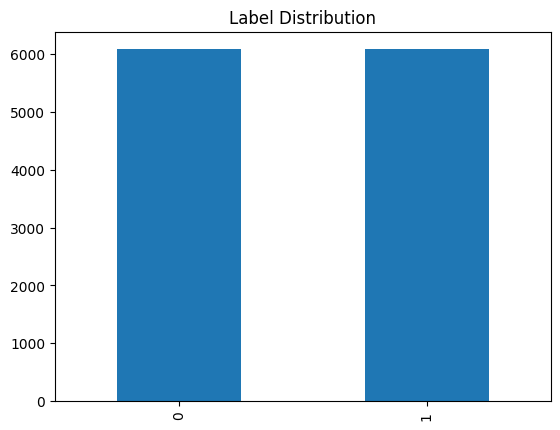

In [7]:
import matplotlib.pyplot as plt
train_df.label.value_counts().plot(kind='bar', title='Label Distribution')
print(train_df.label.value_counts(normalize=True))

## 1. Naive Bayes Classifier (Preprocessed with BoW and TF-IDF)

In [8]:
naive_bayes_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [9]:
train_X = train_df['text'].to_numpy('str')
train_Y = train_df['label'].to_numpy('int')
print(train_X.dtype, train_Y.dtype)

<U5493 int64


In [10]:
naive_bayes_clf.fit(train_X, train_Y)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [11]:
# Load test datasets
test_X = test_df['text'].to_numpy('str')
test_Y = test_df['label'].to_numpy('int')
print(len(test_X))
print(len(test_Y))

2093
2093


In [12]:
print(len(test_df[test_df['label'] == 0]))
print(len(test_df[test_df['label'] == 1]))

1894
199


In [13]:
predicted = naive_bayes_clf.predict(test_X)

In [15]:
# Evaluation Functions
# Based on https://github.com/Perez-AlmendrosC/dontpatronizeme/blob/master/semeval-2022/evaluation.py


def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)


def precision(y_true, y_pred):
    return precision_score(y_true, y_pred)


def recall(y_true, y_pred):
    return recall_score(y_true, y_pred)


def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)

In [16]:
# Evaluate Naive Bayes model.
print("Accuracy: ", accuracy(test_Y, predicted))
print("Precision: ", precision(test_Y, predicted))
print("Recall: ", recall(test_Y, predicted))
print("F1: ", f1(test_Y, predicted))

Accuracy:  0.7711419015766842
Precision:  0.2426470588235294
Recall:  0.6633165829145728
F1:  0.35531628532974424


# 2. Logistic Regression.

In [17]:
from sklearn.linear_model import LogisticRegression


logistic_regression_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

In [18]:
logistic_regression_clf.fit(train_X, train_Y)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [19]:
predicted = logistic_regression_clf.predict(test_X)

In [20]:
# Evaluate Naive Bayes model.
print("Accuracy: ", accuracy(test_Y, predicted))
print("Precision: ", precision(test_Y, predicted))
print("Recall: ", recall(test_Y, predicted))
print("F1: ", f1(test_Y, predicted))

Accuracy:  0.8652651696129957
Precision:  0.35335689045936397
Recall:  0.5025125628140703
F1:  0.41493775933609955
